In [96]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchSimulation.utils import show_symb

def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=filtering'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_list(Rx, Tx, Ntest=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2], 10000):
        Q.append(np.mean(BER(torch.from_numpy(Rx[t:t+Ntest]), torch.from_numpy(Tx[t:t+Ntest]))['Qsq']))
    return Q

f = h5py.File('dataset_exp/train_x4.h5', 'r')

for key in f.keys():
    print('Nch, Rs, Pch, symbs, NF, SF, L:', f[key].attrs['Nch'], f[key].attrs['Rs(GHz)'], f[key].attrs['Pch(dBm)'], f[key]['SymbTx'].shape[1], f[key].attrs['NF(dB)'], f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'], f[key].attrs['distance(km)'])

Nch, Rs, Pch, symbs, NF, SF, L: 11 80 0 250000 4.5 1.2 2000


In [94]:
f.visit(print)

Nmodes2_Rs80_Nch11_Pch0_699094917
Nmodes2_Rs80_Nch11_Pch0_699094917/Rx(sps=2,chid=0,method=frequency cut)
Nmodes2_Rs80_Nch11_Pch0_699094917/Rx(sps=2,chid=0,method=frequency cut)/Rx
Nmodes2_Rs80_Nch11_Pch0_699094917/Rx(sps=2,chid=0,method=frequency cut)/Rx_CDC
Nmodes2_Rs80_Nch11_Pch0_699094917/Rx(sps=2,chid=0,method=frequency cut)/Tx
Nmodes2_Rs80_Nch11_Pch0_699094917/Rx(sps=2,chid=0,method=frequency cut)/info
Nmodes2_Rs80_Nch11_Pch0_699094917/SignalRx
Nmodes2_Rs80_Nch11_Pch0_699094917/SignalTx
Nmodes2_Rs80_Nch11_Pch0_699094917/SymbTx
Nmodes2_Rs80_Nch11_Pch0_699094917/pulse


In [95]:
f.close()

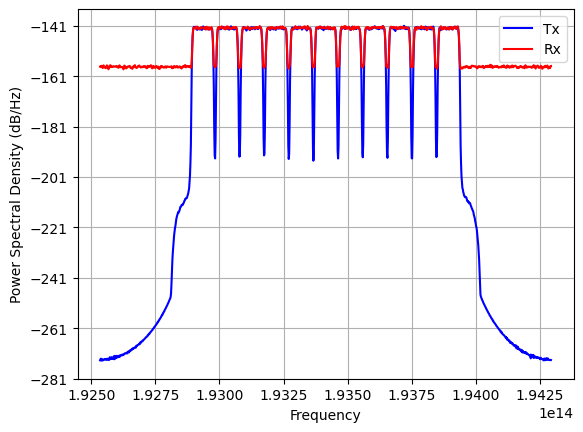

In [42]:
grp = get_signal(f, 11, 80, 0, 250000, 4.5, 1.2, 2000)
_ = plt.psd(grp['SignalTx'][...][0,200000:400000,0], NFFT=1024, Fs=grp['SignalTx'].attrs['sps']*grp.attrs['Rs(GHz)']*1e9, Fc=grp.attrs['Fc(Hz)'], scale_by_freq=True, color='b', label='Tx')
_ = plt.psd(grp['SignalRx'][...][0,200000:400000,0], NFFT=1024, Fs=grp['SignalRx'].attrs['sps']*grp.attrs['Rs(GHz)']*1e9, Fc=grp.attrs['Fc(Hz)'], scale_by_freq=True, color='r', label='Rx')
plt.legend()

(7.0, 8.0)

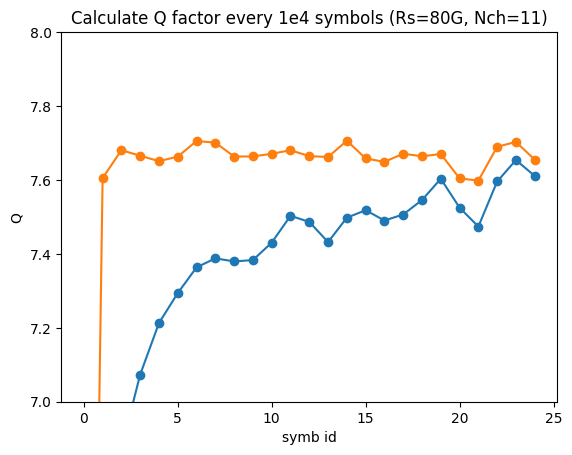

In [92]:
import numpy as np


grp = get_grp(f, 11, 80, 0, 250000, 4.5, 1.2, 2000)
Q1 = Q_list(grp['Rx_CDCDDLMS'][0], grp['Tx'][0,7:-8], Ntest=20000)
plt.plot(Q1, '-o')


grp = get_grp(f, 11, 80, 0, 250000, 4.5, 1.2, 2000, tag='')
Q2 = Q_list(grp['Rx_CDCDDLMS'][0], grp['Tx'][0,7:-8], Ntest=20000)
plt.plot(Q2, '-o')

plt.xlabel('symb id')
plt.ylabel('Q')
plt.title('Calculate Q factor every 1e4 symbols (Rs=80G, Nch=11)')

plt.ylim(7, 8)

In [81]:
from src.TorchDSP.baselines import DDLMS

grp = get_grp(f, 11, 80, 0, 250000, 4.5, 1.2, 2000)

N = 200000
sps = grp['Rx_CDC'].attrs['sps']
E =  torch.from_numpy(grp['Rx_CDC'][:,0:N*sps:])
Tx = torch.from_numpy(grp['Tx'][:,0:N]).to(torch.complex64)

In [82]:
F = DDLMS(E, Tx, sps, lr=[1/2**6, 1/2**7])
Q3 = Q_list(F.val[0].numpy(), Tx[0,7:-8].numpy())


F = DDLMS(E, Tx, sps, lr=[1/2**6, 1/2**6])
Q4 = Q_list(F.val[0].numpy(), Tx[0,7:-8].numpy())


F = DDLMS(E, Tx, sps, lr=[1/2**5, 1/2**5])
Q5 = Q_list(F.val[0].numpy(), Tx[0,7:-8].numpy())

F = DDLMS(E, Tx, sps, lr=[1/2**5, 1/2**6])
Q6 = Q_list(F.val[0].numpy(), Tx[0,7:-8].numpy())

In [86]:
F = DDLMS(E, Tx, sps, lr=[1/2**4, 1/2**4])
Q7 = Q_list(F.val[0].numpy(), Tx[0,7:-8].numpy())

(7.0, 8.0)

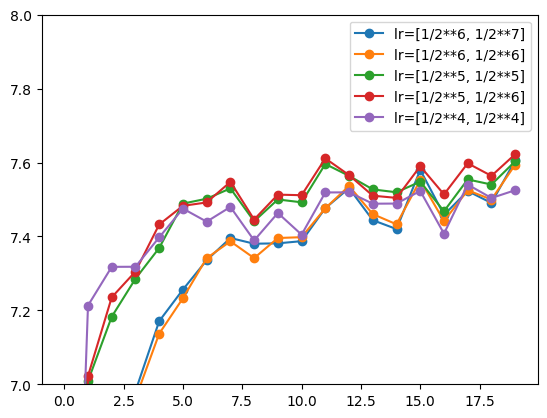

In [87]:
plt.plot(Q3, '-o', label='lr=[1/2**6, 1/2**7]')
plt.plot(Q4, '-o', label='lr=[1/2**6, 1/2**6]')
plt.plot(Q5, '-o', label='lr=[1/2**5, 1/2**5]')
plt.plot(Q6, '-o', label='lr=[1/2**5, 1/2**6]')
plt.plot(Q7, '-o', label='lr=[1/2**4, 1/2**4]')
plt.legend()
plt.ylim(7, 8)

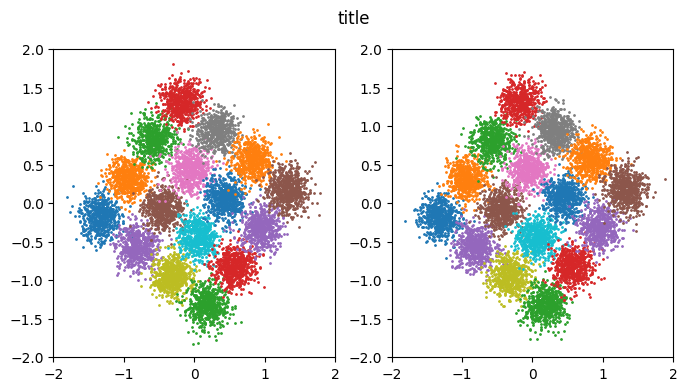

In [25]:
def show_symb(sig,symb,s=10,figsize=(8,4),title='title'):
    '''
    sig,symb: L2 = 1    [Nsymb, Nmodes]
    '''
    Nmodes = sig.shape[-1]
    symb_set = np.unique(symb)

    fig, ax = plt.subplots(1,2, figsize=figsize)
    fig.suptitle(title)

    for p in range(Nmodes):
        ax[p].set_xlim(-2,2)
        ax[p].set_ylim(-2,2)
        for sym in symb_set:
            
            z = sig[...,p][symb[...,p] == sym]
            ax[p].scatter(z.real, z.imag, s=s)

grp = get_grp(f, 11, 80, 0, 250000, 4.5, 1.2, 2000, tag='')
# grp = get_grp(f, 11, 80, -20, 250000, -100, 1.2)

t = 4000
show_symb(grp['Rx_CDC'][0,0::2][t:t+10000], grp['Tx'][0,t:t+10000], s=1)

In [1]:
from src.TorchSimulation.transmitter import  simpleWDMTx 
from src.TorchSimulation.receiver import simpleRx
from src.TorchSimulation.utils import show_symb
import matplotlib.pyplot as plt, numpy as np, torch

Sample rate fa: 2.56e+12, Cut off frequency fc: 3e+11, fa > 2fc: True
 simpleWDMTx complete, time cost(s):1.2943542003631592
Sample rate fa: 5.12e+12, Cut off frequency fc: 3e+11, fa > 2fc: True
 simpleWDMTx complete, time cost(s):1.0450105667114258


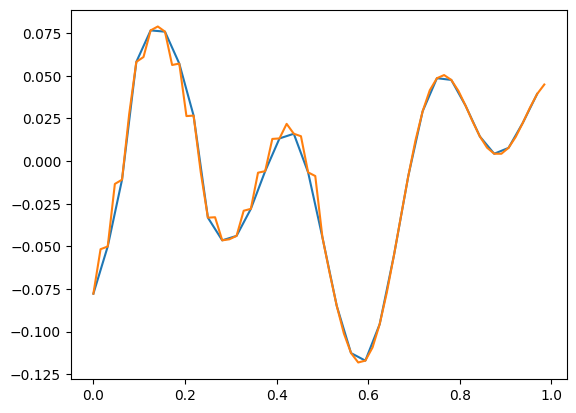

In [2]:
Nch = 5

sps = 32
tx_data = simpleWDMTx(123, 1, 16, Nbits=1000000, sps=sps, Nch=Nch, Nmodes=1, Rs=80e9, freqspace=80e9*1.5, Pch_dBm=0, Ai=1, Vpi=2, Vb=-2, Ntaps=2**16, roll=0.2, pulse_type='rc', device='cuda:0')
plt.plot(np.linspace(0,1,sps, endpoint=False), tx_data['signal'].squeeze().real.roll(sps//2)[0:sps])

sps = 64
tx_data = simpleWDMTx(123, 1, 16, Nbits=1000000, sps=sps, Nch=Nch, Nmodes=1, Rs=80e9, freqspace=80e9*1.5, Pch_dBm=0, Ai=1, Vpi=2, Vb=-2, Ntaps=2**16, roll=0.2, pulse_type='rc', device='cuda:0')
plt.plot(np.linspace(0,1,sps, endpoint=False), tx_data['signal'].squeeze().real.roll(sps//2)[0:sps])

In [22]:
from src.TorchSimulation.transmitter import  simpleWDMTx 
from src.TorchSimulation.receiver import simpleRx, rx
from src.TorchSimulation.utils import show_symb
import matplotlib.pyplot as plt, numpy as np, torch

Nch = 11
sps = 32
tx_data = simpleWDMTx(123, 1, 16, Nbits=800000, sps=sps, Nch=Nch, Nmodes=1, Rs=10e9, freqspace=10e9*1.2, Pch_dBm=0, Ai=1, Vpi=2, Vb=-2, Ntaps=2**10, roll=0.1, pulse_type='rc', device='cuda:0')

Sample rate fa: 3.2e+11, Cut off frequency fc: 6.6e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):0.6944441795349121


In [24]:
freq= tx_data['config']['freqspace']

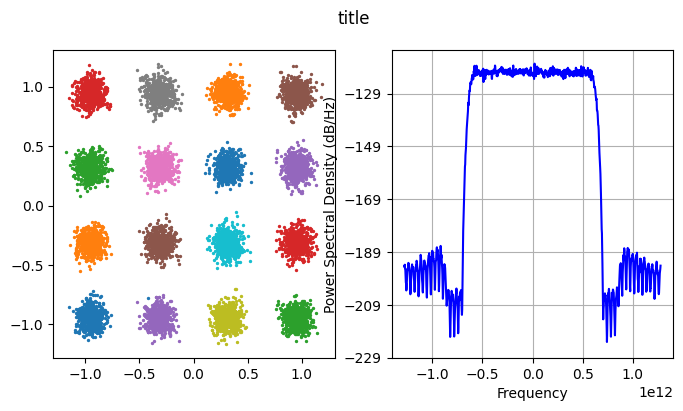

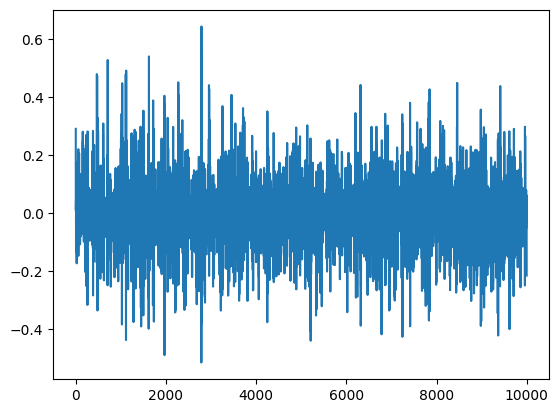

In [27]:
chid = 5
rx_sps = 2
FO = 0
lw = 0


t0 = -10000
sig = tx_data['signal'].roll(-t0*sps, dims=1)[:,0:sps*10000,:]
sym = tx_data['SymbTx'].roll(-t0, dims=1)[0,0:10000,chid]
# rx_data = simpleRx(234, sig, tx_data['config'], chid, rx_sps, FO=FO, lw=lw, phi_lo=0,Plo_dBm=1, method='frequency cut', device='cpu')['signal']
rx_data = simpleRx(234, sig, tx_data['config'], chid, rx_sps, FO=FO, lw=lw, phi_lo=0,Plo_dBm=1, method='filtering', device='cpu')['signal']
# rx_data = rx(sig, chid, sps, rx_sps, Nch, tx_data['config']['Rs']  * sps, tx_data['config']['freqspace'])
show_symb(rx_data[0,0::rx_sps], sym, s=2)
_ = plt.psd(rx_data[0,::1, 0], NFFT=1024, Fs=80e9*32, Fc=0, scale_by_freq=True, color='b')

plt.figure()
plt.plot(torch.angle(rx_data[0,::2] / sym))

# t0 = -10000
# sig = tx_data['signal'].roll(-t0*sps, dims=1)[:,0:sps*10000,:]
# sym = tx_data['SymbTx'].roll(-t0, dims=1)[0,0:10000,chid]
# rx_data = simpleRx(234, sig, tx_data['config'], chid, rx_sps, FO=0, lw=0, phi_lo=0,Plo_dBm=1, method='filtering', device='cpu')
# show_symb(rx_data['signal'][0,0::rx_sps], sym, s=1)


In [12]:
FO = 64e6
lw = 100e4
rx_data1 = simpleRx(234, sig, tx_data['config'], chid, rx_sps, FO=FO, lw=lw, phi_lo=0,Plo_dBm=1, method='filtering', device='cpu')
rx_data2 = simpleRx(234, sig, tx_data['config'], chid, rx_sps, FO=FO, lw=lw, phi_lo=0,Plo_dBm=1, method='frequency cut', device='cpu')

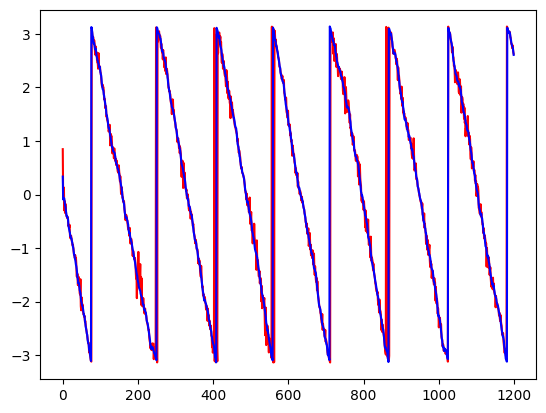

In [14]:
plt.plot(torch.angle(rx_data1['signal'][0,::2,0] / sym[:,0])[0:1200], color='r')
plt.plot(torch.angle(rx_data2['signal'][0,::2,0] / sym[:,0])[0:1200], color='b')

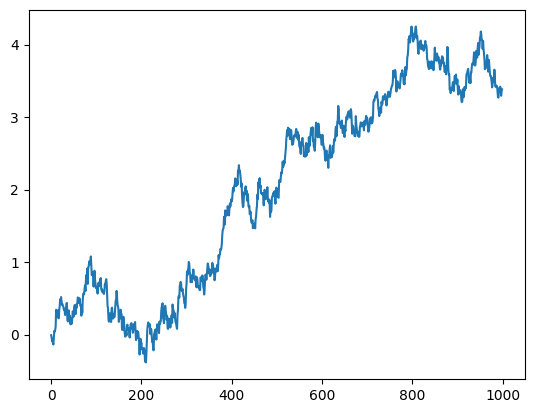

In [9]:
import torch, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import phaseNoise

plt.plot(phaseNoise(1, 100e3, 1000,  1e-8, torch.float64)[0])